In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [2]:

X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/TBaptisteData/X.txt',index_col=None,delim_whitespace=True,header=None)

print(X_all)

          0       1       2       3       4       5       6       7       8
0    3.0312  1.0938  3.0312  1.0938  3.0312  0.5300  4.1875  0.0013  0.5750
1    1.0938  3.0312  1.0938  3.0312  1.0938  1.3300  2.5625  0.0038  0.8250
2    3.5156  3.5156  0.6094  2.5469  1.5781  0.7300  3.7812  0.0007  0.7625
3    2.5469  0.6094  1.5781  1.5781  0.6094  1.1300  4.5938  0.0044  0.6375
4    0.6094  2.5469  3.5156  3.5156  2.5469  0.3300  2.9688  0.0019  0.8875
..      ...     ...     ...     ...     ...     ...     ...     ...     ...
195  2.7815  2.8118  3.4778  3.4929  2.9631  1.4269  3.4956  0.0014  0.5643
196  3.7502  1.8430  2.5090  0.5867  3.9319  0.2269  4.3081  0.0026  0.9393
197  1.8127  3.7805  0.5715  2.5242  1.9944  1.0269  2.6831  0.0001  0.6893
198  1.3284  1.3586  3.9622  2.0398  3.4475  1.2269  2.2769  0.0020  0.7518
199  3.2659  3.2961  2.0247  3.9773  1.5100  0.4269  3.9019  0.0044  0.5018

[200 rows x 9 columns]


In [3]:

y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/TBaptisteData/Y.txt',index_col=None,delim_whitespace=True,header=None)

print(y_all)

          0       1       2       3       4       5         6
0    4.8305  3.8516  6.9308  4.9914  7.3701  2.7390   96.8291
1    4.4470  2.9320  6.5672  5.1431  6.8284  3.0203   82.9983
2    5.0224  3.7737  6.7237  5.4473  7.5285  3.5713   92.7497
3    5.0951  4.1124  6.8647  5.8018  7.2604  2.9882   94.1621
4    6.4672  5.0741  8.3397  7.3326  8.2225  5.3466   99.6714
..      ...     ...     ...     ...     ...     ...       ...
195  4.7734  3.5972  6.4952  4.5640  7.3232  3.8472   79.2038
196  5.4355  4.1194  7.7660  7.8032  6.2576  2.8540  101.8850
197  5.0889  3.7123  6.8856  4.4706  7.8700  4.8034   82.1303
198  4.1495  3.1454  5.8185  4.6743  6.2808  2.4151   79.5085
199  5.5497  4.1478  7.5671  5.4456  8.3492  4.5198   94.5070

[200 rows x 7 columns]


In [4]:
X_all.shape

(200, 9)

# Emulator

In [5]:
y_train = torch.tensor(y_all.values)
x_train = torch.tensor(X_all.values)

In [6]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3
4
5
6


In [7]:
y_train[100]

tensor([ 4.3384,  2.7007,  6.7765,  5.3975,  5.8045,  3.3102, 79.3666],
       dtype=torch.float64)

In [8]:
nDim = X_all.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(X_all.iloc[:,i]),np.max(X_all.iloc[:,i])])
    print(boundsMaxMin[i])

[0.1553, 3.9924]
[0.1704, 3.9546]
[0.2385, 3.9924]
[0.1553, 3.9773]
[0.1704, 3.9849]
[0.1362, 1.7175]
[1.7627, 4.9937]
[0.0001, 0.005]
[0.4539, 0.948]


In [9]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [10]:
import emcee
ndim = nDim
nwalkers = 18
p0 = np.random.multivariate_normal(centre, 0.000000001*np.identity(ndim), size=(nwalkers))
y_val = y_train[100]

In [11]:
boundsMaxMin

[[0.1553, 3.9924],
 [0.1704, 3.9546],
 [0.2385, 3.9924],
 [0.1553, 3.9773],
 [0.1704, 3.9849],
 [0.1362, 1.7175],
 [1.7627, 4.9937],
 [0.0001, 0.005],
 [0.4539, 0.948]]

In [12]:
np.array(boundsMaxMin)[:,0]*2

array([3.1060e-01, 3.4080e-01, 4.7700e-01, 3.1060e-01, 3.4080e-01,
       2.7240e-01, 3.5254e+00, 2.0000e-04, 9.0780e-01])

In [13]:
p0[0]

array([2.07380788e+00, 2.06252991e+00, 2.11544877e+00, 2.06630017e+00,
       2.07761175e+00, 9.26857239e-01, 3.37818481e+00, 2.52366990e-03,
       7.00942123e-01])

In [14]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]*0.5<theta).all() and (theta<np.array(boundsMaxMin)[:,1]*2).all():
        return 0.0
    return -np.inf

In [15]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        return 0.0
    return -np.inf

In [16]:
x=torch.tensor(p0[0])[None]
ll =np.sum(emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],torch.ones(9)*0.01).detach().numpy())

In [17]:
def log_likelihood(x,emulator,y_val):
    x=torch.tensor(x)[None]
    ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],[0.01,0.01,0.01,0.01,0.01,0.01,0.01,1e-6,0.01])).detach().numpy())
    return ll

In [18]:
log_likelihood(p0[1],emulator,y_val)

-13.820022

In [19]:
def log_prob(theta, emulator,y_val):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(theta,emulator, y_val)

In [20]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [21]:
p0[i].shape

(9,)

In [22]:
torch.tensor(p0[0]).shape

torch.Size([9])

In [23]:
emulator.predict(torch.tensor(p0)).shape

torch.Size([18, 7])

In [24]:
for i in range(16):
    print(log_prob(p0[i],emulator,y_val))

-13.830707550048828
-13.820021629333496
-13.810632705688477
-13.852134704589844
-13.845767974853516
-13.811875343322754
-13.808526992797852
-13.836013793945312
-13.828044891357422
-13.81800651550293
-13.823022842407227
-13.815084457397461
-13.806730270385742
-13.794979095458984
-13.818845748901367
-13.801065444946289


In [25]:
import scipy

In [26]:
def neg_log_likelihood(x,emulator,y_val):
    x=torch.tensor(x)[None]
    ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],[0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001])).detach().numpy())
    return -ll

In [27]:
bds=np.array(boundsMaxMin)

In [28]:
result = scipy.optimize.minimize(neg_log_likelihood, p0[0], args=(emulator,y_val), method='Nelder-Mead', tol=1e-8,bounds=bds)


In [29]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3.5464210510253906
             x: [ 7.301e-01  3.954e+00  3.383e+00  1.458e+00  3.287e+00
                  1.533e+00  2.926e+00  2.433e-03  9.346e-01]
           nit: 1142
          nfev: 1773
 final_simplex: (array([[ 7.301e-01,  3.954e+00, ...,  2.433e-03,
                         9.346e-01],
                       [ 7.301e-01,  3.954e+00, ...,  2.433e-03,
                         9.346e-01],
                       ...,
                       [ 7.301e-01,  3.954e+00, ...,  2.433e-03,
                         9.346e-01],
                       [ 7.301e-01,  3.954e+00, ...,  2.433e-03,
                         9.346e-01]]), array([ 3.546e+00,  3.546e+00,  3.546e+00,  3.546e+00,
                        3.546e+00,  3.546e+00,  3.546e+00,  3.546e+00,
                        3.546e+00,  3.546e+00]))

In [30]:
result.x

array([7.30092070e-01, 3.95412054e+00, 3.38286330e+00, 1.45810071e+00,
       3.28717527e+00, 1.53304248e+00, 2.92601425e+00, 2.43292285e-03,
       9.34599021e-01])

In [31]:
log_likelihood(p0[1],emulator,y_val)

-13.820022

In [32]:
sampler.run_mcmc(p0, 80000)

State([[2.47185198e+00 3.81691329e+00 1.76890974e+00 9.61432875e-01
  3.77353211e-01 1.48752187e+00 2.02582782e+00 2.52235120e-03
  7.81730899e-01]
 [4.82642182e-01 3.58053435e+00 2.44488674e+00 2.89626557e+00
  9.10180410e-01 1.67697545e+00 2.01081648e+00 3.17768028e-03
  7.63911014e-01]
 [1.44876793e+00 3.20929923e+00 3.57724833e+00 2.05430920e-01
  3.83645486e+00 1.49936421e+00 2.41507877e+00 1.20967596e-03
  6.59710330e-01]
 [3.39061254e+00 2.91237948e+00 2.69517722e+00 3.66007737e+00
  1.26242881e+00 1.35581413e+00 2.44618997e+00 4.60165855e-03
  8.06669145e-01]
 [6.30629953e-01 3.37351823e+00 3.82252554e+00 1.24876079e+00
  3.73954794e+00 1.35601105e+00 2.29358404e+00 3.84112197e-03
  8.77939335e-01]
 [1.23565147e+00 2.79200362e+00 8.30288725e-01 1.77710954e+00
  2.87551753e+00 1.48521688e+00 2.98150285e+00 2.42932008e-03
  7.06637887e-01]
 [3.56888206e-01 3.88736648e+00 2.79152495e+00 6.04358017e-01
  1.27212845e+00 1.69384411e+00 3.31435193e+00 1.94844997e-03
  9.42739836e-01]


In [33]:
flat_samples = sampler.get_chain(discard=20000, thin=10, flat=True)
print(flat_samples.shape)

(108000, 9)


In [34]:
y_val

tensor([ 4.3384,  2.7007,  6.7765,  5.3975,  5.8045,  3.3102, 79.3666],
       dtype=torch.float64)

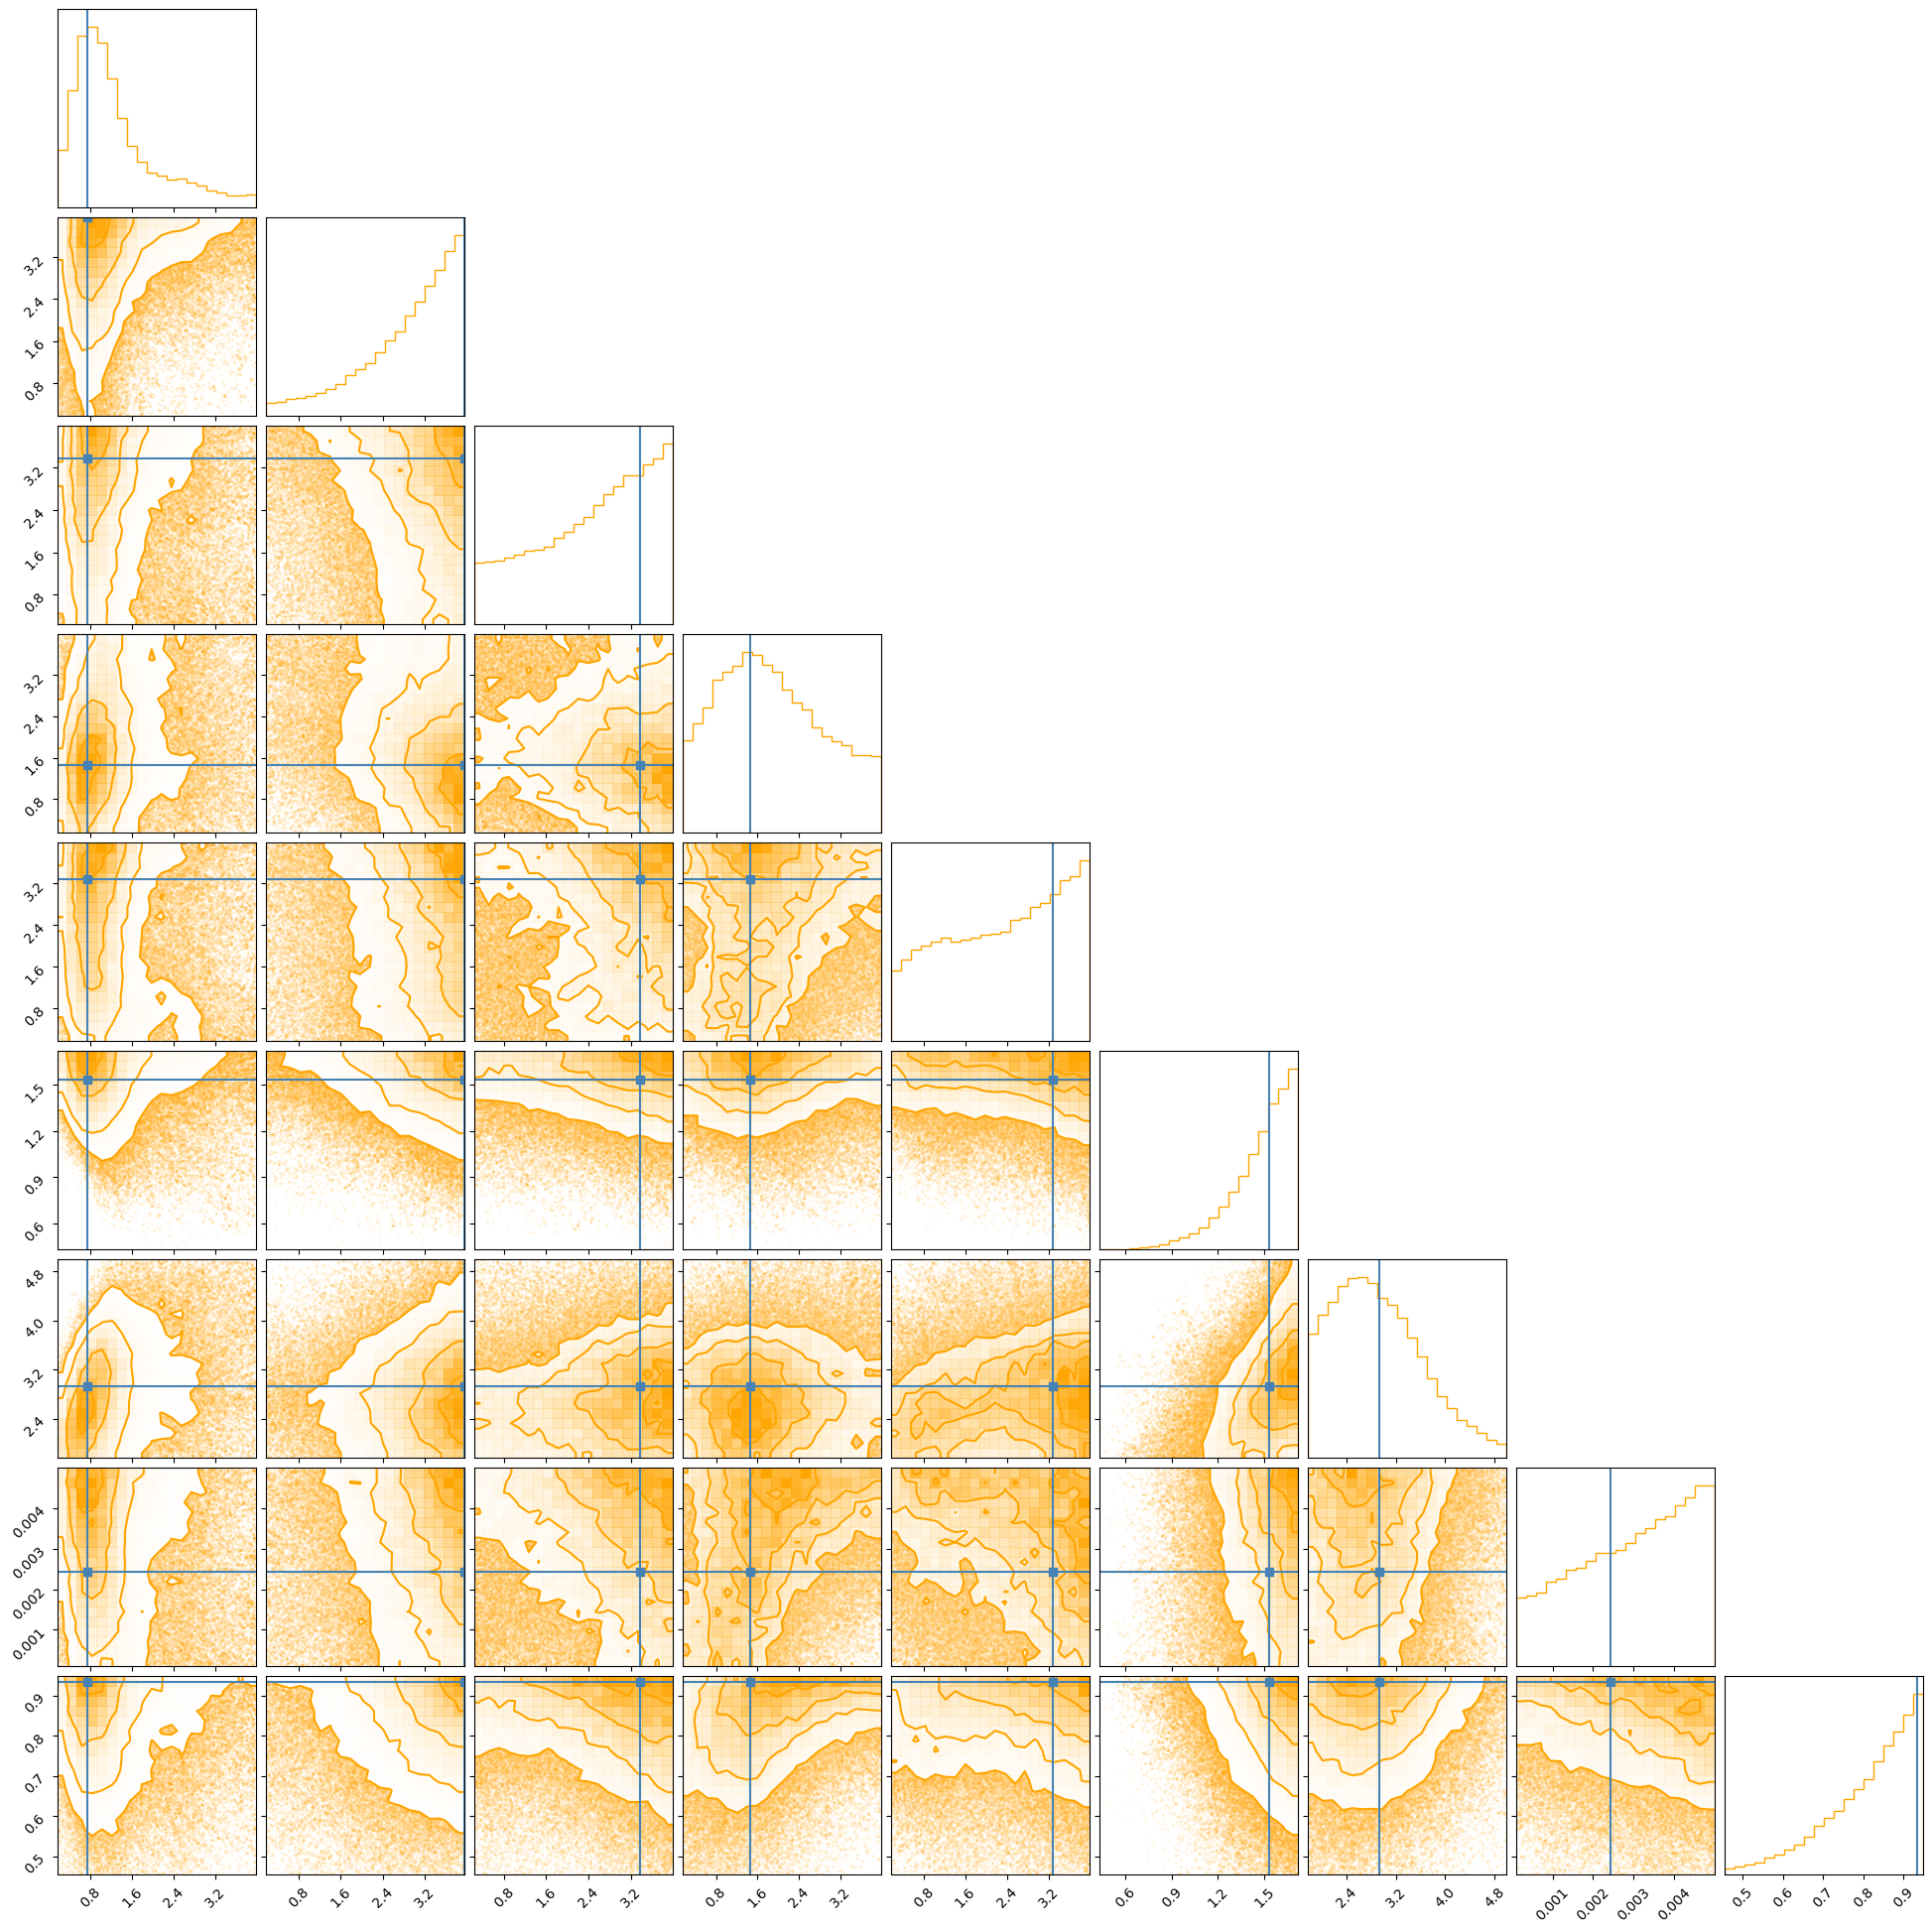

In [35]:
import corner

fig = corner.corner(
    flat_samples, label_kwargs=dict(fontsize=18),color='orange',truths=result.x
);

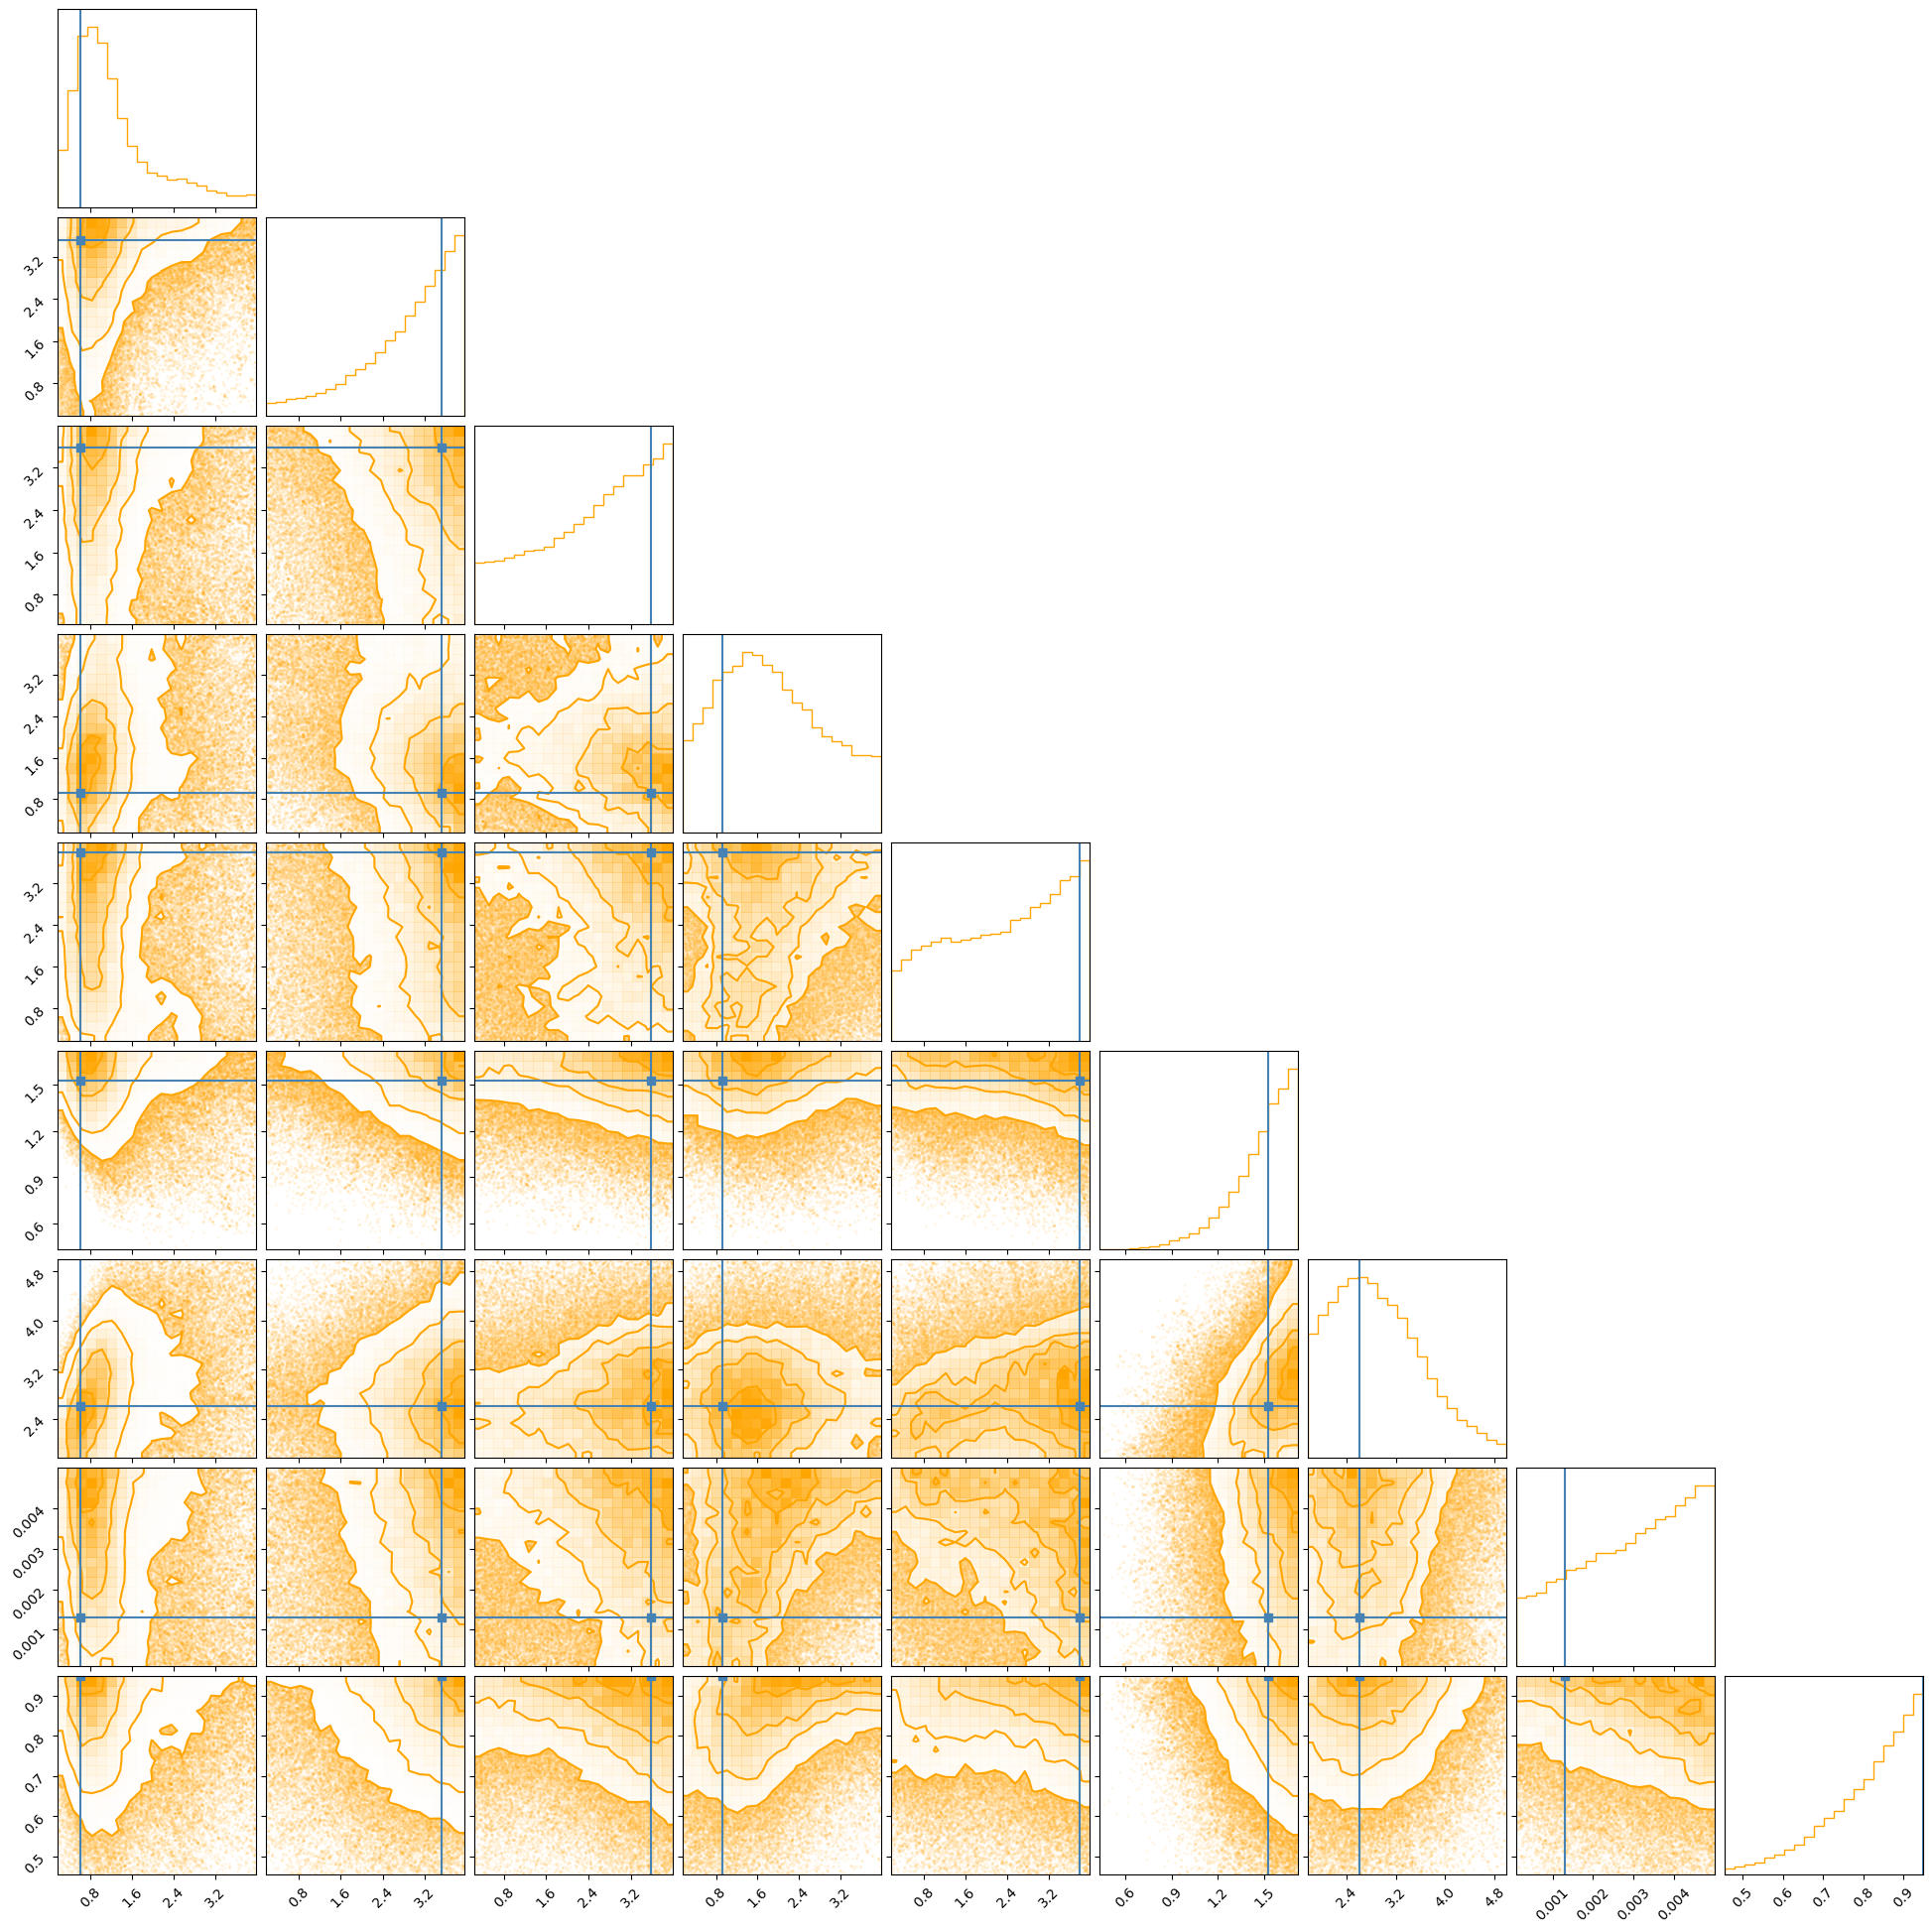

In [36]:
import corner

fig = corner.corner(
    flat_samples, label_kwargs=dict(fontsize=18),color='orange',truths=x_train[100]
);

In [37]:
samp = pd.DataFrame(flat_samples).sample(50)

In [38]:
samp.to_csv("MCMC_samples_scenario_6_80_2timesUpper.dat", sep = " ",index=False,header=None)

In [39]:
flat_samples.mean(axis=0)

array([1.27638362, 2.8663493 , 2.49724734, 1.88601522, 2.33088681,
       1.47372322, 2.91658544, 0.00295754, 0.8125076 ])

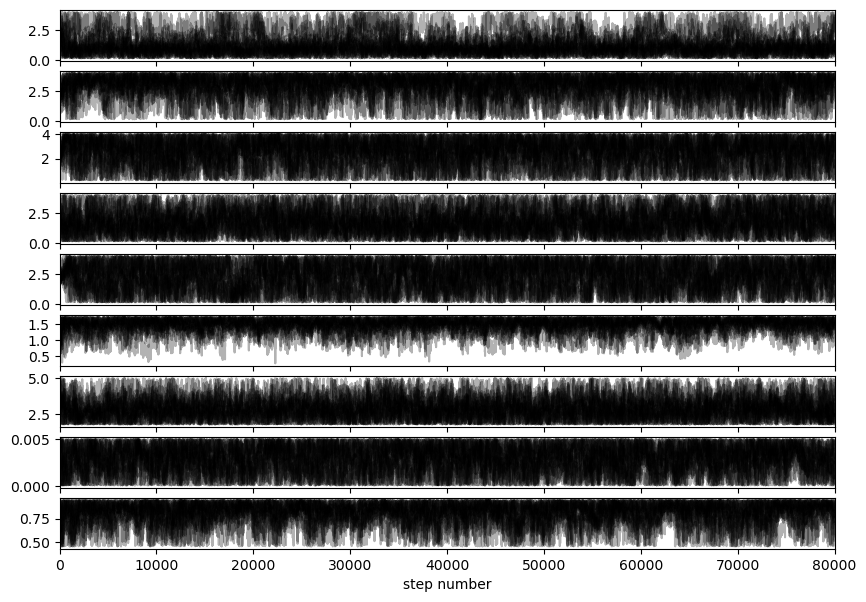

In [40]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [41]:
x_out = torch.tensor(flat_samples.mean(axis=0).T)


In [42]:
X_all.iloc[100]

0    0.5942
1    3.5308
2    3.5913
3    0.9272
4    3.8032
5    1.5238
6    2.6006
7    0.0013
8    0.9480
Name: 100, dtype: float64

In [43]:
emulator.predict(x_out[None,:])

tensor([[ 4.0899,  2.8693,  6.2247,  4.6778,  6.2471,  2.4278, 80.8752]],
       grad_fn=<PermuteBackward0>)

In [44]:
x_all=torch.tensor(X_all.values)

In [45]:
y_all=torch.tensor(y_all.values)


In [46]:
y_test = y_all[45,:]
x_test = x_all[45,:]

y_train = y_all[~torch.all(y_all == y_test, dim=1)]
x_train = x_all[~torch.all(x_all == x_test, dim=1)]

In [47]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3
4
5
6


In [48]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_test])

In [49]:
for i in range(16):
    print(log_prob(p0[i],emulator,y_val))

-13.605490684509277
-13.59521484375
-13.58619213104248
-13.626079559326172
-13.620027542114258
-13.587373733520508
-13.584157943725586
-13.610593795776367
-13.602921485900879
-13.593267440795898
-13.598087310791016
-13.590472221374512
-13.58248519897461
-13.571182250976562
-13.594093322753906
-13.577030181884766


In [50]:
sampler.run_mcmc(p0, 40000)

State([[2.86888969e+00 3.01408585e+00 1.29905591e+00 3.76444527e-01
  3.18122023e+00 1.93118500e-01 4.22200419e+00 2.84758727e-03
  6.26453825e-01]
 [3.57027734e+00 3.23536048e+00 1.72169666e+00 7.94155944e-01
  3.14239178e+00 1.60021601e-01 3.88052635e+00 3.00914712e-03
  7.31189148e-01]
 [6.80901083e-01 3.45159936e-01 4.17343166e-01 2.19329123e+00
  2.04962197e+00 5.57665067e-01 3.17604372e+00 3.65055042e-03
  6.61476549e-01]
 [2.87624795e+00 1.24285756e+00 5.89360659e-01 1.90177856e+00
  2.84700508e+00 3.20647052e-01 3.70871177e+00 3.74202679e-03
  5.31694592e-01]
 [3.93414168e+00 3.13907037e-01 2.73604245e-01 2.36770895e-01
  3.00518461e+00 2.07629319e-01 3.38186758e+00 1.21632072e-03
  5.87574815e-01]
 [2.56063911e+00 2.43939960e+00 1.62208068e+00 3.36908775e-01
  2.64880051e+00 1.66836434e-01 3.47960752e+00 4.56712700e-03
  8.19007261e-01]
 [2.20137720e+00 3.80391083e+00 1.49870809e+00 2.03690469e+00
  2.80541074e+00 2.47147939e-01 4.24935342e+00 4.89815227e-03
  7.00338303e-01]


In [51]:
flat_samples = sampler.get_chain(discard=8000, thin=1, flat=True)
print(flat_samples.shape)

(576000, 9)


ValueError: Provided figure has 81 axes, but data has dimensions K=7

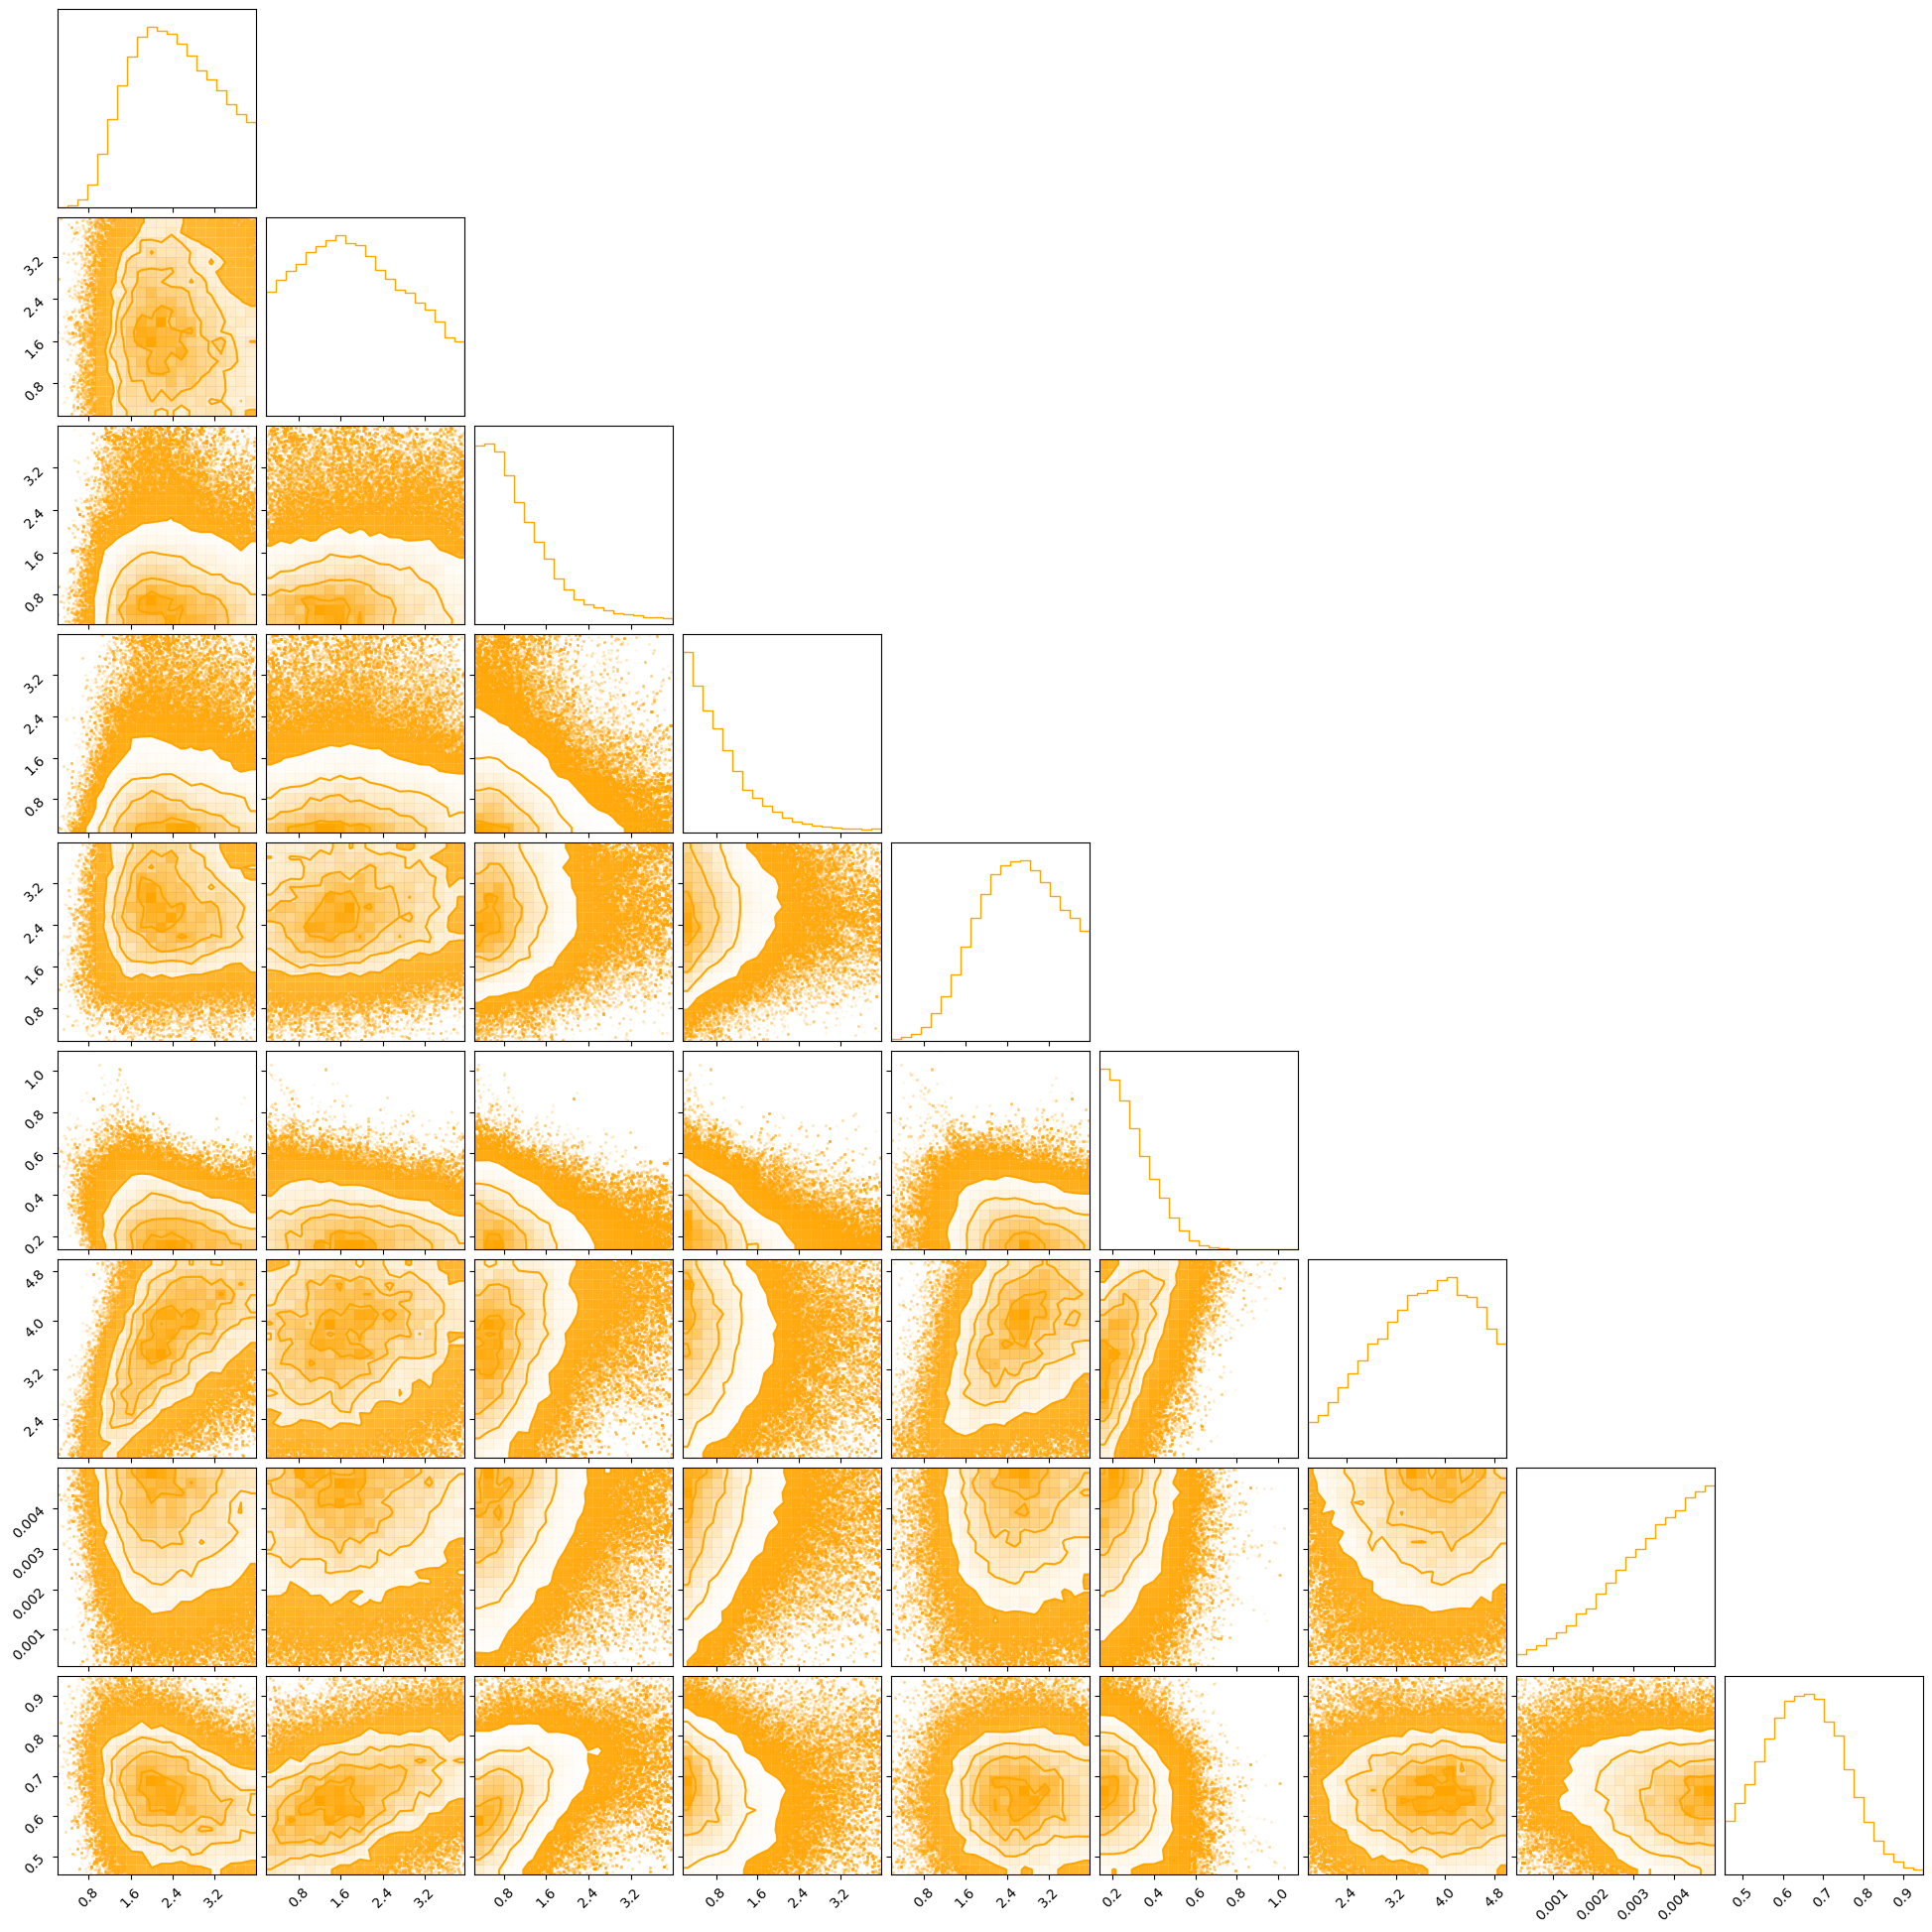

In [52]:
import corner

fig = corner.corner(
    flat_samples, label_kwargs=dict(fontsize=18),color='orange',truths=y_test
);